In [121]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


In [122]:
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

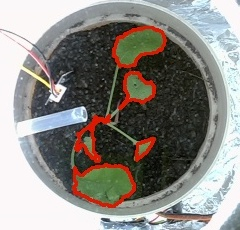

In [123]:
img = cv2.imread('download.jpeg')
img = img[90:320, 210:450]
original = img.copy()
imshow(img)

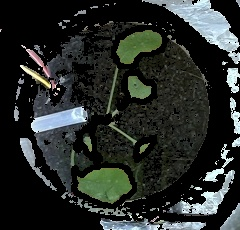

In [124]:

def remove_white_from_image(img):
    # Read the image
    image = img

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for white colors
    lower_white = np.array([20,20,20], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)

    # Create a mask for white colors
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Apply the mask to the image
    result = cv2.bitwise_and(image, image, mask=white_mask)

    return result

img = remove_white_from_image(img)
imshow(img)

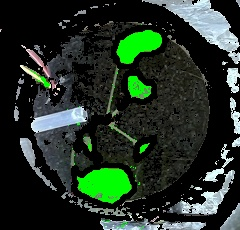

In [125]:
## Convert to HSV

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
greenMask = cv2.inRange(hsv, (26, 80, 60), (105, 250, 255))

img[greenMask == 255] = (0, 255, 0)

imshow(img)

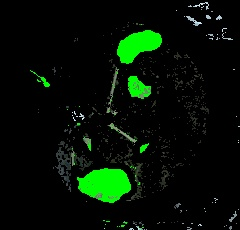

In [126]:

# Read the input image

# Convert to HSV to get better control over color range
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the range for green in HSV
lower_green = np.array([35, 40, 40])  # Adjust these values if necessary
upper_green = np.array([100, 255, 255])

# Create a mask that isolates the green color
mask = cv2.inRange(hsv, lower_green, upper_green)

# Convert single-channel mask to three channels for bitwise operations
mask3 = cv2.merge([mask, mask, mask])

# Extract the green region using bitwise AND
green = cv2.bitwise_and(img, mask3)

# Convert the original image to grayscale and then back to BGR
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# Extract the non-green region
non_green = cv2.bitwise_and(gray_bgr, cv2.bitwise_not(mask3))

# Combine the green region with the grayscale non-green region
out = cv2.add(non_green, green)

imshow(green)
img = green


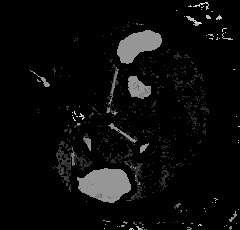

In [127]:




#image grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

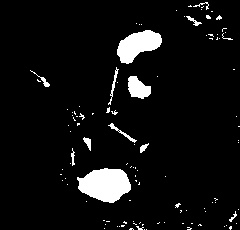

In [128]:

#Threshold Processing
ret, bin_img = cv2.threshold(gray,
                             0, 255,
                             cv2.THRESH_OTSU)

imshow(bin_img)

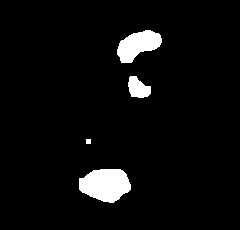

In [129]:




# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img,
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
imshow(bin_img)

In [130]:
non_zero_pixels = cv2.countNonZero(bin_img)
print(f"Number of non-zero pixels: {non_zero_pixels}")
print(f"Green Area: {non_zero_pixels * 5/4175} cm²")

Number of non-zero pixels: 2616
Green Area: 3.132934131736527 cm²


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


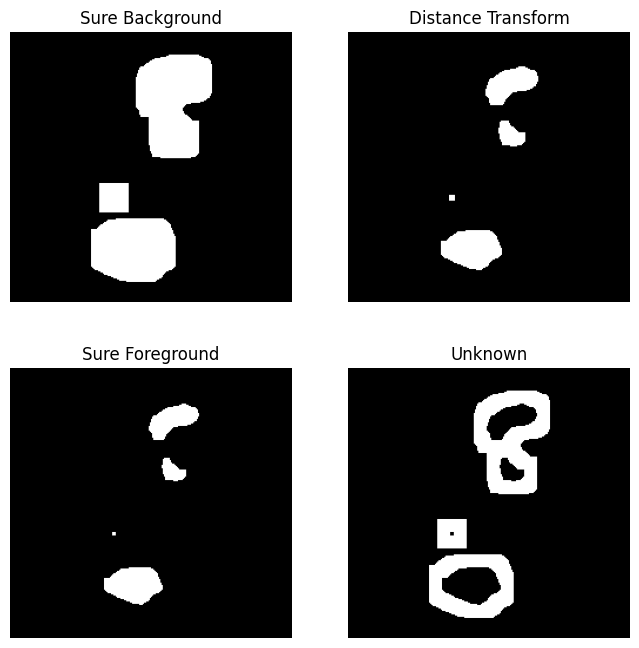

In [131]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=10)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 0)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()

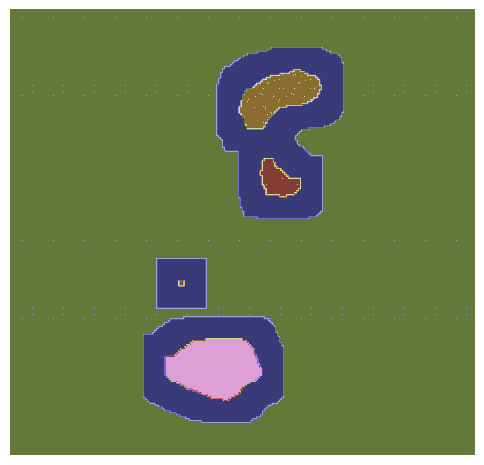

In [132]:

# Marker labelling
# sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

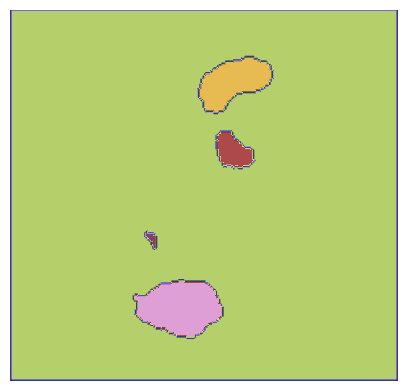

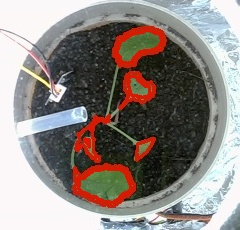

In [133]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:

# Create a binary image in which only the area of the label is in the foreground
#and the rest of the image is in the background
    target = np.where(markers == label, 255, 0).astype(np.uint8)

  # Perform contour extraction on the created binary image
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(original, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)